## Libraries and data download

In [34]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean #pip install clean-text
import re
# from sklearn.model_selection import train_test_split
from datasets import Dataset, ClassLabel, Value, Features,DatasetDict



In [14]:
# Download latest version
path = kagglehub.dataset_download("datasnaek/mbti-type")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\Tim\.cache\kagglehub\datasets\datasnaek\mbti-type\versions\1


In [15]:
df = pd.read_csv("C:/Users/Tim/.cache/kagglehub/datasets/datasnaek/mbti-type/versions/1/mbti_1.csv")

df.head()
length_df = len(df)

# Target variable distribution 

In [16]:
target_exp = pd.DataFrame(columns = ["type", "counts", "percentage"])
target_exp["type"] = df["type"].unique()
target_exp = df["type"].value_counts().reset_index()
target_exp["percentage"] = round(target_exp["count"] / target_exp["count"].sum() * 100, ndigits = 3)
for i in range(4):
    target_exp[f"axis {i+1} (I/E)"] = target_exp["type"].str[i]

target_exp.loc[[0],["approx. general pop. freq."]] = 7
target_exp.loc[[1],["approx. general pop. freq."]] = 2
target_exp.loc[[2],["approx. general pop. freq."]] = 4
target_exp.loc[[3],["approx. general pop. freq."]] = 3
target_exp.loc[[4],["approx. general pop. freq."]] = 3.5
target_exp.loc[[5],["approx. general pop. freq."]] = 7
target_exp.loc[[6],["approx. general pop. freq."]] = 5
target_exp.loc[[7],["approx. general pop. freq."]] = 7
target_exp.loc[[8],["approx. general pop. freq."]] = 3.5
target_exp.loc[[9],["approx. general pop. freq."]] = 12.5
target_exp.loc[[10],["approx. general pop. freq."]] = 3.5
target_exp.loc[[11],["approx. general pop. freq."]] = 11.5
target_exp.loc[[12],["approx. general pop. freq."]] = 4.5
target_exp.loc[[13],["approx. general pop. freq."]] = 6.5
target_exp.loc[[14],["approx. general pop. freq."]] = 11
target_exp.loc[[15],["approx. general pop. freq."]] = 10


target_exp


,type,count,percentage,axis 1 (I/E),axis 2 (I/E),axis 3 (I/E),axis 4 (I/E),approx. general pop. freq.
0,INFP,1832,21.118,I,N,F,P,7.0
1,INFJ,1470,16.945,I,N,F,J,2.0
2,INTP,1304,15.032,I,N,T,P,4.0
3,INTJ,1091,12.576,I,N,T,J,3.0
4,ENTP,685,7.896,E,N,T,P,3.5
5,ENFP,675,7.781,E,N,F,P,7.0
6,ISTP,337,3.885,I,S,T,P,5.0
7,ISFP,271,3.124,I,S,F,P,7.0
8,ENTJ,231,2.663,E,N,T,J,3.5
9,ISTJ,205,2.363,I,S,T,J,12.5


# Plotting Distribution

C:\Users\Tim\AppData\Local\Temp\ipykernel_15944\1888248834.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'MBTI Distribution Dataset vs General Population')

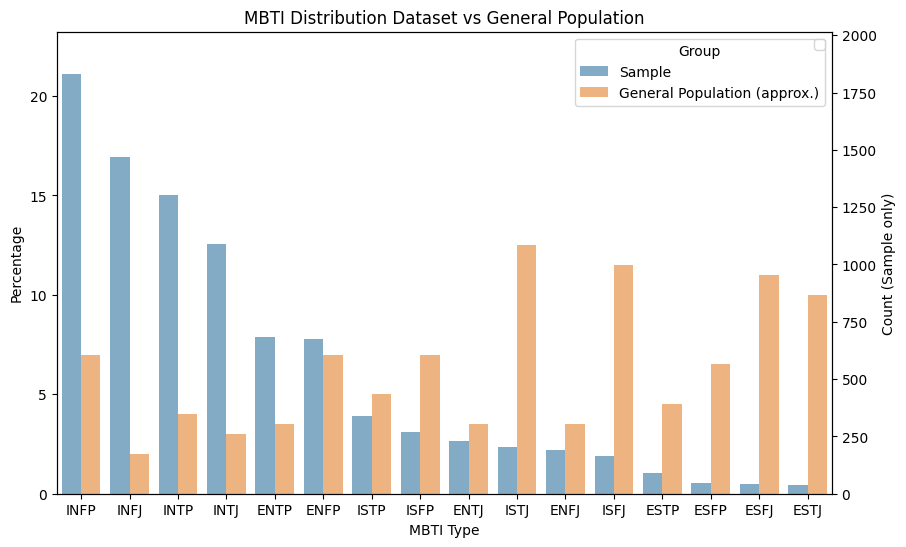

In [17]:
plot_data = target_exp.melt(
    id_vars = "type",
    value_vars= ["percentage", "approx. general pop. freq."],
    var_name = "Group",
    value_name = "Percentage"
)

plot_data["Group"] = plot_data["Group"].replace({
    "percentage": "Sample",
    "approx. general pop. freq.": "General Population (approx.)"
})

fig, ax1 = plt.subplots(figsize=(10,6))


sns.barplot(data = plot_data, x = "type", y = "Percentage", hue = "Group", alpha = 0.6)
ax1.set_ylabel("Percentage")
ax2 = ax1.twinx()

ax2.set_ylabel("Count (Sample only)")
total_n = target_exp["count"].sum()
max_perc = max(target_exp["percentage"].max(), target_exp["approx. general pop. freq."].max())


ax1.set_ylim(0, max_perc * 1.1)  
ax2.set_ylim(0, (max_perc * 1.1) * total_n / 100)
ax1.set_xlabel("MBTI Type")
plt.legend()
plt.title("MBTI Distribution Dataset vs General Population")

# Data Cleaning and Splitting
- mask urls
- mask emails
- mask phone numbers
- mask ip addresses
- mask file paths
- mask mbti type mentions
- drop rows with less than 30 characters
- drop rows that are only numeric
- drop duplicates

## Splitting
Each observation of "posts" in the dataset represents a collection of forum posts by a user. Since these posts are usually not related and there is no "dialogue"-like structure to them, splitting them allows for generating more data points ("50-times more") without any/much loss of information.

In [18]:
# cleaning function
def clean_data(text):
    return clean(text,
           fix_unicode = True,
           no_urls = True,
           no_emails = True,
           no_file_paths = True,
           no_phone_numbers = True,
           no_ip_addresses = True
           #no_emoji=True
           )

# splitting function
def split_strings(data, col_to_split, separator):
    dfcopy = data.copy().astype(str)
    dfcopy[col_to_split] = dfcopy[col_to_split].str.split(pat = separator, regex=False)
    return dfcopy.explode(col_to_split).reset_index(drop = True)


# replace mbti mentions
def replace_mbti(text):
    pattern = r'\b(infj|infp|intj|intp|isfj|isfp|istj|istp|enfj|enfp|entj|entp|esfj|esfp|estj|estp)\b'
    return re.sub(pattern, "<mbti>", text, flags=re.IGNORECASE)

def preprocessing_pipe(df, col_to_clean, col_cleaned, separator):
    # cleaning
    df[col_cleaned] = df[col_to_clean].apply(clean_data)

    #mbti type removal
    df[col_cleaned] = df[col_cleaned].apply(replace_mbti)

    #splitting
    df = split_strings(data = df, col_to_split= col_cleaned, separator= separator)

    #drop short posts
    df = df.loc[df[col_cleaned].str.len() > 30].reset_index(drop = True)

    # drop posts that are just numbers
    df = df[~df[col_cleaned].str.isnumeric()]

    # drop possible duplicates
    df = df.drop_duplicates(subset=[col_cleaned])
    df = df.drop(columns=[col_to_clean])
    return df


df_clean = preprocessing_pipe(df, "posts", "posts_cleaned", "|||")
length_cleaned = len(df_clean)


# Comparison cleaned vs not cleaned

In [19]:
print(f"Length of initial dataset: {length_df} \n Length of cleaned dataset: {length_cleaned}")

Length of initial dataset: 8675 
 Length of cleaned dataset: 370596


In [20]:
target_exp_clean = pd.DataFrame(columns = ["type", "counts", "percentage"])
target_exp_clean["type"] = df_clean["type"].unique()
target_exp_clean = df_clean["type"].value_counts().reset_index()
target_exp_clean["percentage"] = round(target_exp_clean["count"] / target_exp_clean["count"].sum() * 100, ndigits = 3)
for i in range(4):
    target_exp_clean[f"axis {i+1} (I/E)"] = target_exp_clean["type"].str[i]

target_exp_clean.loc[[0],["approx. general pop. freq."]] = 7
target_exp_clean.loc[[1],["approx. general pop. freq."]] = 2
target_exp_clean.loc[[2],["approx. general pop. freq."]] = 4
target_exp_clean.loc[[3],["approx. general pop. freq."]] = 3
target_exp_clean.loc[[4],["approx. general pop. freq."]] = 3.5
target_exp_clean.loc[[5],["approx. general pop. freq."]] = 7
target_exp_clean.loc[[6],["approx. general pop. freq."]] = 5
target_exp_clean.loc[[7],["approx. general pop. freq."]] = 7
target_exp_clean.loc[[8],["approx. general pop. freq."]] = 3.5
target_exp_clean.loc[[9],["approx. general pop. freq."]] = 12.5
target_exp_clean.loc[[10],["approx. general pop. freq."]] = 3.5
target_exp_clean.loc[[11],["approx. general pop. freq."]] = 11.5
target_exp_clean.loc[[12],["approx. general pop. freq."]] = 4.5
target_exp_clean.loc[[13],["approx. general pop. freq."]] = 6.5
target_exp_clean.loc[[14],["approx. general pop. freq."]] = 11
target_exp_clean.loc[[15],["approx. general pop. freq."]] = 10


target_exp_clean

,type,count,percentage,axis 1 (I/E),axis 2 (I/E),axis 3 (I/E),axis 4 (I/E),approx. general pop. freq.
0,INFP,78049,21.060,I,N,F,P,7.0
1,INFJ,63799,17.215,I,N,F,J,2.0
2,INTP,55586,14.999,I,N,T,P,4.0
3,INTJ,46185,12.462,I,N,T,J,3.0
4,ENTP,29625,7.994,E,N,T,P,3.5
5,ENFP,29287,7.903,E,N,F,P,7.0
6,ISTP,14140,3.815,I,S,T,P,5.0
7,ISFP,10912,2.944,I,S,F,P,7.0
8,ENTJ,9945,2.684,E,N,T,J,3.5
9,ISTJ,8586,2.317,I,S,T,J,12.5


C:\Users\Tim\AppData\Local\Temp\ipykernel_15944\3373569387.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 1.0, 'MBTI Distribution in Cleaned Dataset vs General Population')

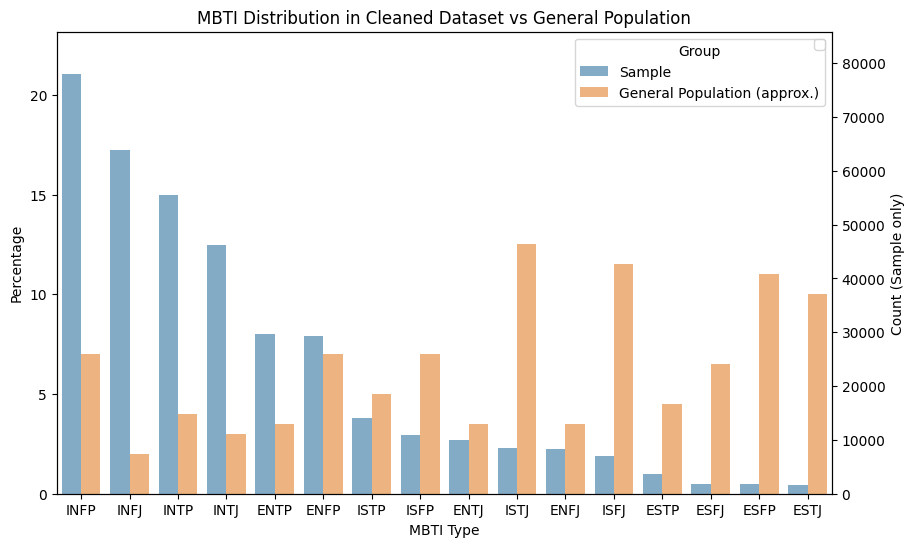

In [21]:


plot_data_clean = target_exp_clean.melt(
    id_vars = "type",
    value_vars= ["percentage", "approx. general pop. freq."],
    var_name = "Group",
    value_name = "Percentage"
)

plot_data_clean["Group"] = plot_data_clean["Group"].replace({
    "percentage": "Sample",
    "approx. general pop. freq.": "General Population (approx.)"
})

fig, ax1 = plt.subplots(figsize=(10,6))


sns.barplot(data = plot_data_clean, x = "type", y = "Percentage", hue = "Group", alpha = 0.6)
ax1.set_ylabel("Percentage")
ax2 = ax1.twinx()

ax2.set_ylabel("Count (Sample only)")
total_n = target_exp_clean["count"].sum()
max_perc = max(target_exp_clean["percentage"].max(), target_exp_clean["approx. general pop. freq."].max())


ax1.set_ylim(0, max_perc * 1.1)  
ax2.set_ylim(0, (max_perc * 1.1) * total_n / 100)
ax1.set_xlabel("MBTI Type")
plt.legend()
plt.title("MBTI Distribution in Cleaned Dataset vs General Population")


C:\Users\Tim\AppData\Local\Temp\ipykernel_15944\3156850932.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


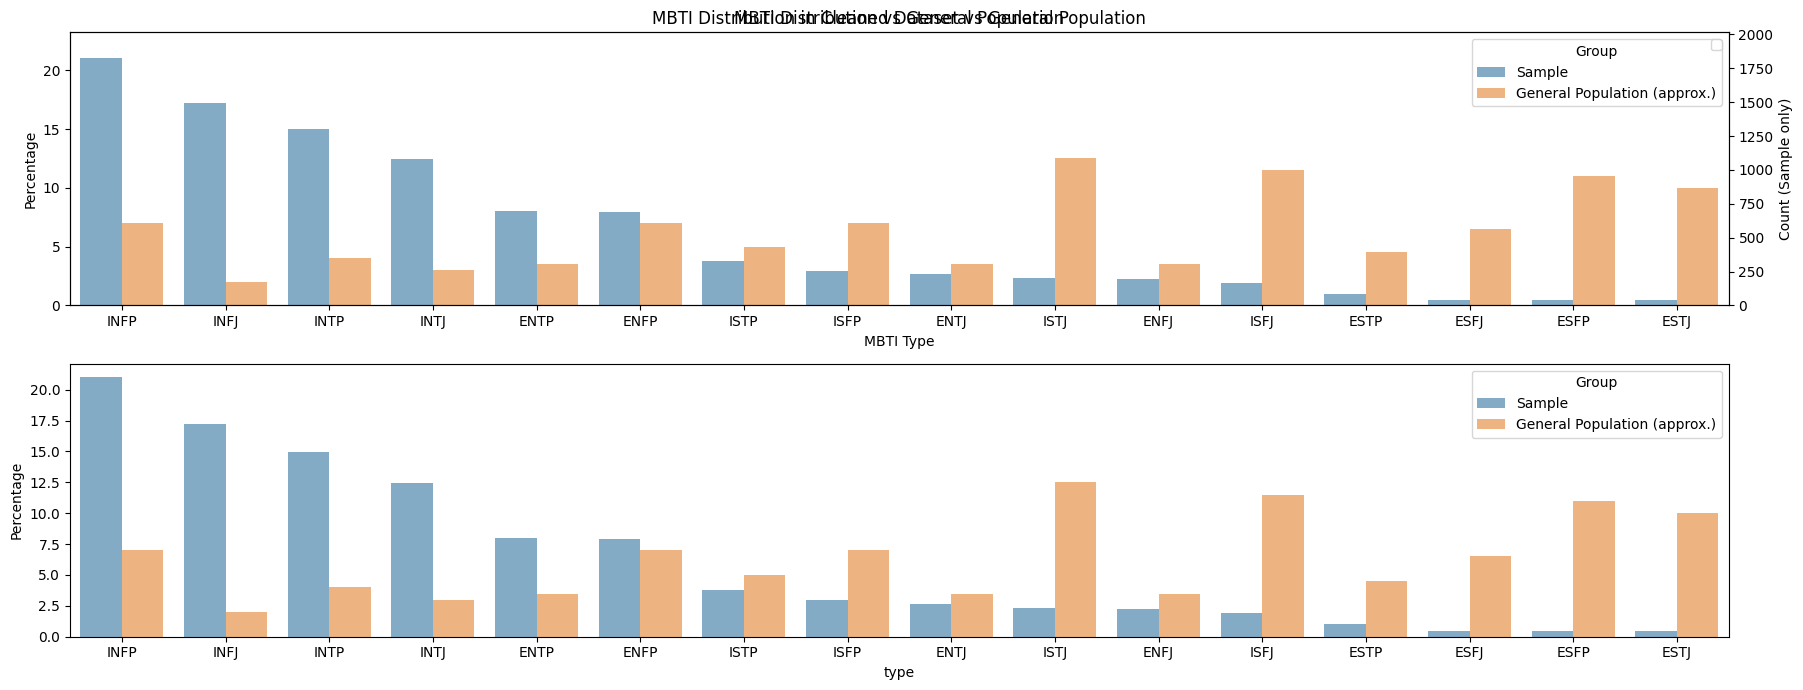

In [22]:
# 1. Erstelle das Grid (1 Zeile, 2 Spalten)
fig, (axes_left, axes_right) = plt.subplots(2, 1, figsize=(18, 7))

# --- DEIN PLOT (kommt auf die linke Seite: axes_left) ---
# Wichtig: ax = axes_left zuweisen!
sns.barplot(data=plot_data_clean, x="type", y="Percentage", hue="Group", alpha=0.6, ax=axes_left)

axes_left.set_ylabel("Percentage")
axes_left.set_xlabel("MBTI Type")

# Jetzt das twinx basierend auf axes_left erstellen
ax2 = axes_left.twinx() 
ax2.set_ylabel("Count (Sample only)")

# Skalierung (Deine Logik übernommen)
total_n = target_exp["count"].sum()
max_perc = max(target_exp["percentage"].max(), target_exp["approx. general pop. freq."].max())

axes_left.set_ylim(0, max_perc * 1.1)
ax2.set_ylim(0, (max_perc * 1.1) * total_n / 100)

axes_left.set_title("MBTI Distribution vs General Population")

# --- DER ZWEITE PLOT (kommt auf die rechte Seite: axes_right) ---
sns.barplot(data = plot_data_clean, x = "type", y = "Percentage", hue = "Group", alpha = 0.6,  ax = axes_right)
ax1.set_ylabel("Percentage")
ax2 = ax1.twinx()

ax2.set_ylabel("Count (Sample only)")
total_n = target_exp_clean["count"].sum()
max_perc = max(target_exp_clean["percentage"].max(), target_exp_clean["approx. general pop. freq."].max())


ax1.set_ylim(0, max_perc * 1.1)  
ax2.set_ylim(0, (max_perc * 1.1) * total_n / 100)
ax1.set_xlabel("MBTI Type")
plt.legend()
plt.title("MBTI Distribution in Cleaned Dataset vs General Population")

plt.tight_layout()
plt.show()

In [43]:
rseed = 42

df_clean = df_clean.rename(columns={"type": "label", "posts_cleaned": "post"})
df_hf = Dataset.from_pandas(df_clean)

df_hf = df_hf.class_encode_column("label")

# class_names = [df_clean["label"].unique()]
# print(class_names)

# features = Features({
#     "post": Value("string"),
#     "label": ClassLabel(names=class_names)
# })

# df_hf = Dataset.from_pandas(df_clean[["post", "label"]], features=features)

split = df_hf.train_test_split(test_size = 0.2, shuffle = True, stratify_by_column="label", seed = rseed)
train = split["train"]
df_temp = split["test"]

split2 = df_temp.train_test_split(test_size = 0.5, shuffle = True, stratify_by_column= "label", seed = rseed)
val = split2["train"]
test = split2["test"]

df_final = DatasetDict({
    "train": train,
    "test": test,
    "validation": val
})

Stringifying the column:   0%|          | 0/370596 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/370596 [00:00<?, ? examples/s]

# Save the dataset

In [ ]:
#df_clean.to_csv("..\data\mbti_cleaned_whole.csv", header = ["label", "post"], index = False)
#df_final.save_to_disk("..\data\mbti_dict")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Tim\AppData\Local\Temp\ipykernel_15944\3666300598.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_final.save_to_disk("..\data\mbti_dict")


Saving the dataset (0/1 shards):   0%|          | 0/296476 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37060 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37060 [00:00<?, ? examples/s]

# Notes:
- split before cleaning
- drop rows under ??? words/characters
    - drop rows that are only numbers

After cleaning is done, plot distribution again